In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

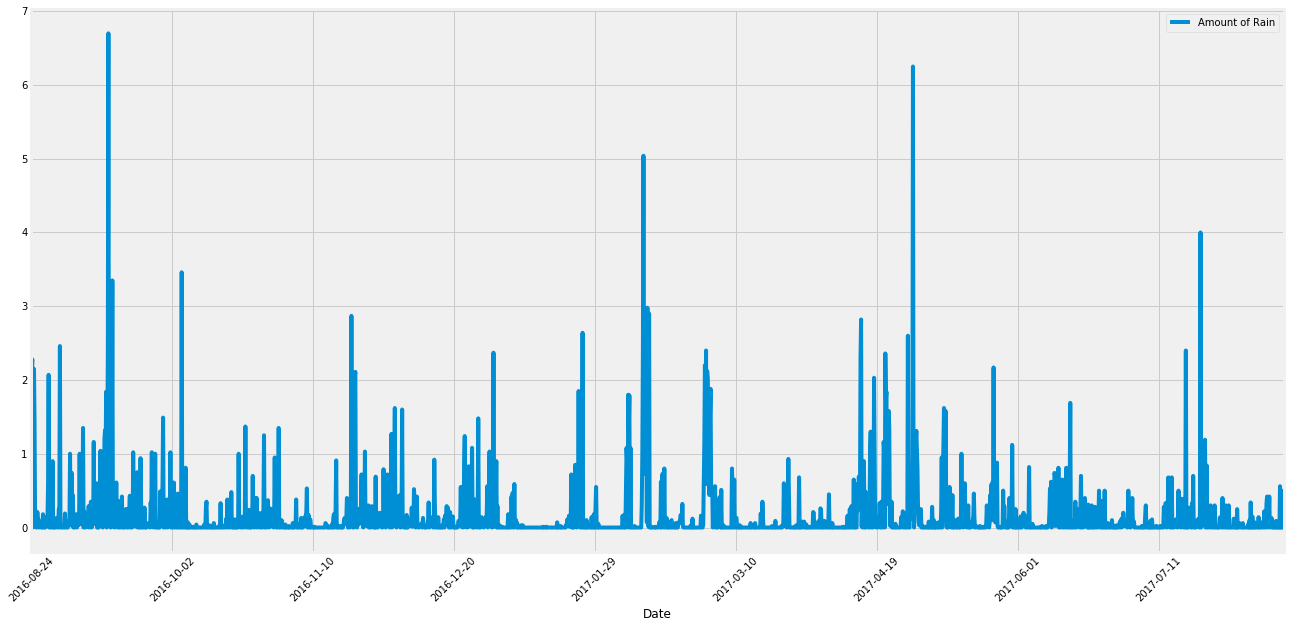

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Determine the last day that data was collected in the available info.
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# print(last_day)
# 2017-08-23
# type(last_day)
# str

# Convert str to datetime obj
last_day = dt.datetime.strptime(last_day, "%Y-%m-%d")
# type(last_day)
# datetime.datetime
# print(last_day)
# 2017-08-23 00:00:00

# Calculate the date 1 year ago from the last data point in the database
first_day = last_day - dt.timedelta(days = 365)
# print(first_day)
# 2016-08-23 00:00:00

# Perform a query to retrieve the data and precipitation scores
year_review = session.query(
    Measurement.date,
    Measurement.prcp
).filter(Measurement.date > first_day).order_by(Measurement.date).all()
# print(year_review)

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_date_df = pd.DataFrame(year_review, columns = ['Date', 'Amount of Rain'])
rain_date_df.set_index(rain_date_df['Date'], inplace = True)
rain_date_df = rain_date_df.fillna(0)
rain_date_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
rain_date_df.plot('Date', 'Amount of Rain', figsize = (20, 10))
plt.xticks(rotation = 45)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_date_df.describe()

,Amount of Rain
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(
    Measurement.station, 
    func.count(Measurement.id)).group_by(
 Measurement.station
).order_by(func.count(Measurement.id).desc()).all()
station_activity                               

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_readings = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == station_activity[0][0]).all()
station_readings

[(54.0, 85.0, 71.66378066378067)]

In [15]:
year_tobs = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date > first_day, Measurement.station == station_activity[0][0]).all()
# year_tobs
year_tobs_df = pd.DataFrame(year_tobs, columns = ['Totals Observed (Tobs)', 'Date'])
year_tobs_df = year_tobs_df.fillna(0)
year_tobs_df.head()

,Totals Observed (Tobs),Date
0,77.0,2016-08-24
1,80.0,2016-08-25
2,80.0,2016-08-26
3,75.0,2016-08-27
4,73.0,2016-08-28


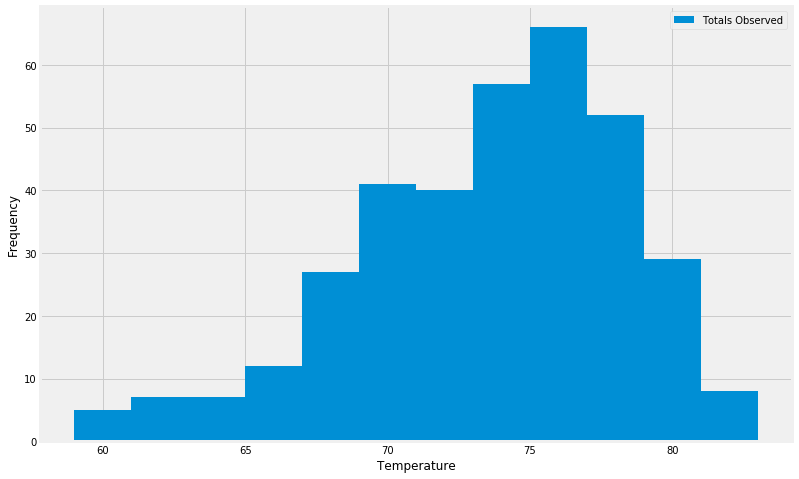

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.figure(figsize = (12, 8))
plt.hist(year_tobs_df['Totals Observed (Tobs)'], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['Totals Observed'])

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_first_day = first_day - dt.timedelta(days = 365)
last_last_day = first_day - dt.timedelta(days = 360)
trip_temps = calc_temps(last_first_day, last_last_day)
tmin, tmax, tavg = trip_temps[0]

86.0

(0, 105)

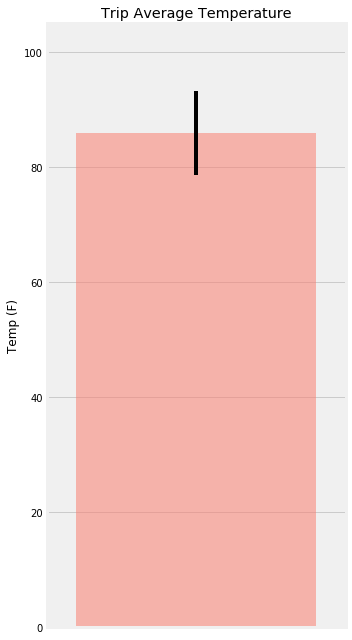

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_bar = tmax - tmin
xpos = 1
height = tavg
plt.figure(figsize = (5, 9))
plt.bar(xpos, height, yerr = error_bar, alpha = .55, color = "salmon")
plt.xticks([0])
plt.yticks(np.arange(0, 120, 20))
plt.ylabel('Temp (F)')
plt.title('Trip Average Temperature')
plt.tight_layout()
plt.xlim(.5, 1.5)
plt.ylim(0, 105)


In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


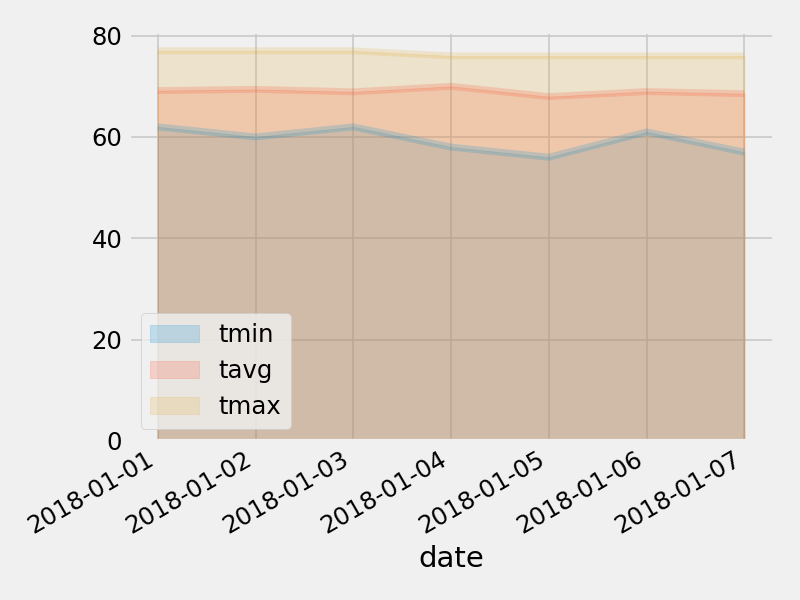

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
